In [126]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [127]:
import copy, math

In [128]:
import plotly.express as px

In [129]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [130]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [131]:
def format_comma(num):
    return f'{num:,.0f}'

# Setup

## Define all keys

In [132]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [133]:
state_labels = list(state_key.values())
state_labels

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu Natal',
 'Limpopo',
 'Mpumalanga',
 'Northern Cape',
 'North-West',
 'Western Cape']

In [134]:
#not required
state_filter_d = copy.deepcopy(state_filter)
state_filter_d.append('Date')
state_filter_d

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [135]:
state_filter_t = copy.deepcopy(state_filter)
state_filter_t.insert(0,'Total RSA')
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [136]:
state_filter_all = copy.deepcopy(state_filter)
state_filter_all.insert(0,'Total RSA')
state_filter_all.append('Date')
state_filter_all

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

## Download SA population stats

In [137]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

Province       Pop
0        Gauteng  15176115
1  KwaZulu-Natal  11289086
2   Western Cape   6844272
3   Eastern Cape   6712276
4        Limpopo   5982584
5     Mpumalanga   4592187
6      Northwest   4027160
7     Free State   2887465
8  Northern Cape   1263875

In [138]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [139]:
province_pops.iloc[0]['Pop']

15176115

In [140]:
state_pop = {
    'EC': 6712276,
    'FS': 2887465,
    'GP': 15176115,
    'KZN': 11289086,
    'LP': 5982584,
    'MP': 4592187,
    'NC': 1263875,
    'NW': 4027160,
    'WC': 6844272
}

# SQL Import Test

In [141]:
import sqlite3

con = sqlite3.connect("../db.sqlite3")

df = pd.read_sql_query('SELECT * FROM dashboard_coviddata', con)
df

id        Date Var   EC   FS   GP  KZN   LP   MP   NC   NW  Unknown  \
0     1295  2020-03-05   C  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0   
1     1296  2020-03-07   C  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0      0.0   
2     1297  2020-03-08   C  0.0  0.0  1.0  2.0  0.0  0.0  0.0  0.0      0.0   
3     1298  2020-03-09   C  0.0  0.0  1.0  6.0  0.0  0.0  0.0  0.0      0.0   
4     1299  2020-03-11   C  0.0  0.0  5.0  7.0  0.0  0.0  0.0  0.0      0.0   
...    ...         ...  ..  ...  ...  ...  ...  ...  ...  ...  ...      ...   
1084  2380  2020-03-09   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
1085  2381  2020-03-10   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
1086  2382  2020-11-27   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
1087  2383  2020-11-28   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   
1088  2384  2020-11-29   T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN   

        Total                                             Source   WC  
0           1                                                0.0  0.0  
1           2                                                0.0  0.0  
2           3                                                0.0  0.0  
3           7                                                0.0  0.0  
4          13                                                0.0  1.0  
...       ...                                                ...  ...  
1084      241                                                0.0  NaN  
1085      241                                                0.0  NaN  
1086  5383078  https://www.nicd.ac.za/latest-confirmed-cases-...  NaN  
1087  5383078  https://www.nicd.ac.za/latest-confirmed-cases-...  NaN  
1088  5383078  https://www.nicd.ac.za/latest-confirmed-cases-...  NaN  

[1089 rows x 15 columns]

# Download Data

## Download case data

In [142]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_cases_i

YYYYMMDD        EC       FS        GP       KZN       LP       MP  \
date                                                                            
2020-03-05  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307       0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308       0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309       0.0      0.0       1.0       6.0      0.0      0.0   
2020-03-11  20200311       0.0      0.0       5.0       7.0      0.0      0.0   
...              ...       ...      ...       ...       ...      ...      ...   
2020-11-25  20201125  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0   
2020-11-26  20201126  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0   
2020-11-27  20201127  124067.0  58946.0  234305.0  127219.0  18520.0  31268.0   
2020-11-28  20201128  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0   
2020-11-29  20201129  126520.0  59014.0  234831.0  127670.0  18573.0  31360.0   

                 NC       NW        WC  UNKNOWN   total  \
date                                                      
2020-03-05      0.0      0.0       0.0      0.0       1   
2020-03-07      0.0      0.0       0.0      0.0       2   
2020-03-08      0.0      0.0       0.0      0.0       3   
2020-03-09      0.0      0.0       0.0      0.0       7   
2020-03-11      0.0      0.0       1.0      0.0      13   
...             ...      ...       ...      ...     ...   
2020-11-25  23044.0  34690.0  127646.0      0.0  775502   
2020-11-26  23095.0  34721.0  128703.0      0.0  778571   
2020-11-27  23118.0  34772.0  129726.0      0.0  781941   
2020-11-28  23156.0  34793.0  130782.0      0.0  785139   
2020-11-29  23185.0  34819.0  131730.0      0.0  787702   

                                                       source  
date                                                           
2020-03-05                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
2020-03-11                                                NaN  
...                                                       ...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  

[268 rows x 13 columns]

In [143]:
casezero = states_cases_i.index[0]
caselast = states_cases_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-11-29 00:00:00'))

In [144]:
idx = pd.date_range(casezero, caselast)
idx

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14',
               ...
               '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23',
               '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27',
               '2020-11-28', '2020-11-29'],
              dtype='datetime64[ns]', length=270, freq='D')

In [145]:
states_cases_i = states_cases_i.reindex(idx, method='ffill')
states_cases_i = states_cases_i.rename(columns={'total':'Total RSA'})
states_cases_i

YYYYMMDD        EC       FS        GP       KZN       LP       MP  \
2020-03-05  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-06  20200305       0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307       0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308       0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309       0.0      0.0       1.0       6.0      0.0      0.0   
...              ...       ...      ...       ...       ...      ...      ...   
2020-11-25  20201125  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0   
2020-11-26  20201126  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0   
2020-11-27  20201127  124067.0  58946.0  234305.0  127219.0  18520.0  31268.0   
2020-11-28  20201128  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0   
2020-11-29  20201129  126520.0  59014.0  234831.0  127670.0  18573.0  31360.0   

                 NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0       0.0      0.0          1   
2020-03-06      0.0      0.0       0.0      0.0          1   
2020-03-07      0.0      0.0       0.0      0.0          2   
2020-03-08      0.0      0.0       0.0      0.0          3   
2020-03-09      0.0      0.0       0.0      0.0          7   
...             ...      ...       ...      ...        ...   
2020-11-25  23044.0  34690.0  127646.0      0.0     775502   
2020-11-26  23095.0  34721.0  128703.0      0.0     778571   
2020-11-27  23118.0  34772.0  129726.0      0.0     781941   
2020-11-28  23156.0  34793.0  130782.0      0.0     785139   
2020-11-29  23185.0  34819.0  131730.0      0.0     787702   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  

[270 rows x 13 columns]

In [146]:
# Validate totals
states_cases_i = states_cases_i[state_filter]
states_cases_i['Total RSA'] = states_cases_i.sum(axis=1)
states_cases_i

EC       FS        GP       KZN       LP       MP       NC  \
2020-03-05       0.0      0.0       0.0       1.0      0.0      0.0      0.0   
2020-03-06       0.0      0.0       0.0       1.0      0.0      0.0      0.0   
2020-03-07       0.0      0.0       1.0       1.0      0.0      0.0      0.0   
2020-03-08       0.0      0.0       1.0       2.0      0.0      0.0      0.0   
2020-03-09       0.0      0.0       1.0       6.0      0.0      0.0      0.0   
...              ...      ...       ...       ...      ...      ...      ...   
2020-11-25  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0  23044.0   
2020-11-26  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0  23095.0   
2020-11-27  124067.0  58946.0  234305.0  127219.0  18520.0  31268.0  23118.0   
2020-11-28  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0  23156.0   
2020-11-29  126520.0  59014.0  234831.0  127670.0  18573.0  31360.0  23185.0   

                 NW        WC  Total RSA  
2020-03-05      0.0       0.0        1.0  
2020-03-06      0.0       0.0        1.0  
2020-03-07      0.0       0.0        2.0  
2020-03-08      0.0       0.0        3.0  
2020-03-09      0.0       0.0        7.0  
...             ...       ...        ...  
2020-11-25  34690.0  127646.0   775502.0  
2020-11-26  34721.0  128703.0   778571.0  
2020-11-27  34772.0  129726.0   781941.0  
2020-11-28  34793.0  130782.0   785139.0  
2020-11-29  34819.0  131730.0   787702.0  

[270 rows x 10 columns]

In [147]:
states_cases = states_cases_i.copy()
states_cases = states_cases.reset_index()
states_cases = states_cases.rename(columns={'index':'Date'})
states_cases

Date        EC       FS        GP       KZN       LP       MP  \
0   2020-03-05       0.0      0.0       0.0       1.0      0.0      0.0   
1   2020-03-06       0.0      0.0       0.0       1.0      0.0      0.0   
2   2020-03-07       0.0      0.0       1.0       1.0      0.0      0.0   
3   2020-03-08       0.0      0.0       1.0       2.0      0.0      0.0   
4   2020-03-09       0.0      0.0       1.0       6.0      0.0      0.0   
..         ...       ...      ...       ...       ...      ...      ...   
265 2020-11-25  121329.0  58846.0  233710.0  126635.0  18439.0  31163.0   
266 2020-11-26  122587.0  58912.0  233995.0  126866.0  18477.0  31215.0   
267 2020-11-27  124067.0  58946.0  234305.0  127219.0  18520.0  31268.0   
268 2020-11-28  125480.0  58983.0  234572.0  127506.0  18550.0  31317.0   
269 2020-11-29  126520.0  59014.0  234831.0  127670.0  18573.0  31360.0   

          NC       NW        WC  Total RSA  
0        0.0      0.0       0.0        1.0  
1        0.0      0.0       0.0        1.0  
2        0.0      0.0       0.0        2.0  
3        0.0      0.0       0.0        3.0  
4        0.0      0.0       0.0        7.0  
..       ...      ...       ...        ...  
265  23044.0  34690.0  127646.0   775502.0  
266  23095.0  34721.0  128703.0   778571.0  
267  23118.0  34772.0  129726.0   781941.0  
268  23156.0  34793.0  130782.0   785139.0  
269  23185.0  34819.0  131730.0   787702.0  

[270 rows x 11 columns]

## Download death data

In [148]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_deaths_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_deaths_i

YYYYMMDD    EC    FS    GP   KZN   LP   MP   NC   NW    WC  \
date                                                                     
2020-03-27  20200327     0     0     0     0    0    0    0    0     1   
2020-03-28  20200328     0     0     0     1    0    0    0    0     1   
2020-03-30  20200330     0     1     0     1    0    0    0    0     1   
2020-03-31  20200331     0     1     1     2    0    0    0    0     1   
2020-04-03  20200403     0     1     1     6    0    0    0    0     1   
...              ...   ...   ...   ...   ...  ...  ...  ...  ...   ...   
2020-11-25  20201125  4475  1870  4996  3321  494  614  306  549  4576   
2020-11-26  20201126  4508  1895  5001  3323  499  614  306  549  4594   
2020-11-27  20201127  4563  1914  5004  3328  499  614  306  549  4601   
2020-11-28  20201128  4589  1914  5005  3340  506  614  306  549  4616   
2020-11-29  20201129  4606  1914  5006  3340  506  614  313  549  4629   

            UNKNOWN  total                                             source  
date                                                                           
2020-03-27        0      1  https://sacoronavirus.co.za/2020/03/27/latest-...  
2020-03-28        0      2                                                NaN  
2020-03-30        0      3                                                NaN  
2020-03-31        0      5                                                NaN  
2020-04-03        0      9                                                NaN  
...             ...    ...                                                ...  
2020-11-25        0  21201  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26        0  21289  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27        0  21378  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28        0  21439  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29        0  21477  https://www.nicd.ac.za/latest-confirmed-cases-...  

[244 rows x 13 columns]

In [149]:
states_deaths_i = states_deaths_i.reindex(idx, method='ffill')
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-06         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-07         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-08         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-09         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-11-25  20201125.0  4475.0  1870.0  4996.0  3321.0  494.0  614.0  306.0   
2020-11-26  20201126.0  4508.0  1895.0  5001.0  3323.0  499.0  614.0  306.0   
2020-11-27  20201127.0  4563.0  1914.0  5004.0  3328.0  499.0  614.0  306.0   
2020-11-28  20201128.0  4589.0  1914.0  5005.0  3340.0  506.0  614.0  306.0   
2020-11-29  20201129.0  4606.0  1914.0  5006.0  3340.0  506.0  614.0  313.0   

               NW      WC  UNKNOWN    total  \
2020-03-05    NaN     NaN      NaN      NaN   
2020-03-06    NaN     NaN      NaN      NaN   
2020-03-07    NaN     NaN      NaN      NaN   
2020-03-08    NaN     NaN      NaN      NaN   
2020-03-09    NaN     NaN      NaN      NaN   
...           ...     ...      ...      ...   
2020-11-25  549.0  4576.0      0.0  21201.0   
2020-11-26  549.0  4594.0      0.0  21289.0   
2020-11-27  549.0  4601.0      0.0  21378.0   
2020-11-28  549.0  4616.0      0.0  21439.0   
2020-11-29  549.0  4629.0      0.0  21477.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  

[270 rows x 13 columns]

In [150]:
states_deaths_i.iloc[0, :] = states_deaths_i.iloc[0, :].replace({np.nan:0})
states_deaths_i = states_deaths_i.ffill(axis=0)
states_deaths_i = states_deaths_i.rename(columns={'total':'Total RSA'})
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-11-25  20201125.0  4475.0  1870.0  4996.0  3321.0  494.0  614.0  306.0   
2020-11-26  20201126.0  4508.0  1895.0  5001.0  3323.0  499.0  614.0  306.0   
2020-11-27  20201127.0  4563.0  1914.0  5004.0  3328.0  499.0  614.0  306.0   
2020-11-28  20201128.0  4589.0  1914.0  5005.0  3340.0  506.0  614.0  306.0   
2020-11-29  20201129.0  4606.0  1914.0  5006.0  3340.0  506.0  614.0  313.0   

               NW      WC  UNKNOWN  Total RSA  \
2020-03-05    0.0     0.0      0.0        0.0   
2020-03-06    0.0     0.0      0.0        0.0   
2020-03-07    0.0     0.0      0.0        0.0   
2020-03-08    0.0     0.0      0.0        0.0   
2020-03-09    0.0     0.0      0.0        0.0   
...           ...     ...      ...        ...   
2020-11-25  549.0  4576.0      0.0    21201.0   
2020-11-26  549.0  4594.0      0.0    21289.0   
2020-11-27  549.0  4601.0      0.0    21378.0   
2020-11-28  549.0  4616.0      0.0    21439.0   
2020-11-29  549.0  4629.0      0.0    21477.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  

[270 rows x 13 columns]

In [151]:
states_deaths = states_deaths_i.copy()
states_deaths = states_deaths.reset_index()
states_deaths = states_deaths.rename(columns={'index':'Date'})
states_deaths

Date    YYYYMMDD      EC      FS      GP     KZN     LP     MP  \
0   2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
1   2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
2   2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
3   2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
4   2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
..         ...         ...     ...     ...     ...     ...    ...    ...   
265 2020-11-25  20201125.0  4475.0  1870.0  4996.0  3321.0  494.0  614.0   
266 2020-11-26  20201126.0  4508.0  1895.0  5001.0  3323.0  499.0  614.0   
267 2020-11-27  20201127.0  4563.0  1914.0  5004.0  3328.0  499.0  614.0   
268 2020-11-28  20201128.0  4589.0  1914.0  5005.0  3340.0  506.0  614.0   
269 2020-11-29  20201129.0  4606.0  1914.0  5006.0  3340.0  506.0  614.0   

        NC     NW      WC  UNKNOWN  Total RSA  \
0      0.0    0.0     0.0      0.0        0.0   
1      0.0    0.0     0.0      0.0        0.0   
2      0.0    0.0     0.0      0.0        0.0   
3      0.0    0.0     0.0      0.0        0.0   
4      0.0    0.0     0.0      0.0        0.0   
..     ...    ...     ...      ...        ...   
265  306.0  549.0  4576.0      0.0    21201.0   
266  306.0  549.0  4594.0      0.0    21289.0   
267  306.0  549.0  4601.0      0.0    21378.0   
268  306.0  549.0  4616.0      0.0    21439.0   
269  313.0  549.0  4629.0      0.0    21477.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
265  https://www.nicd.ac.za/latest-confirmed-cases-...  
266  https://www.nicd.ac.za/latest-confirmed-cases-...  
267  https://www.nicd.ac.za/latest-confirmed-cases-...  
268  https://www.nicd.ac.za/latest-confirmed-cases-...  
269  https://www.nicd.ac.za/latest-confirmed-cases-...  

[270 rows x 14 columns]

## Download recovery data

In [152]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_recovery_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_recovery_i

YYYYMMDD      EC     FS        GP     KZN     LP     MP     NC  \
date                                                                         
2020-04-17  20200417       9     71     479.0      96     18      9     10   
2020-04-18  20200418       9     71     479.0      96     18      9     10   
2020-04-19  20200419       9     71     479.0      96     18      9     10   
2020-04-20  20200420      15     74     545.0     151     21     14     13   
2020-04-21  20200421      15     74     545.0     151     21     14     13   
...              ...     ...    ...       ...     ...    ...    ...    ...   
2020-11-25  20201125  107116  50174       NaN  117329  17637  30150  19449   
2020-11-26  20201126  109170  50532       NaN  117376  17662  30166  20061   
2020-11-27  20201127  109170  50629  228365.0  117405  17696  30234  20645   
2020-11-28  20201128  109170  50629  228365.0  117461  17696  30291  20653   
2020-11-29  20201129  114808  51083  228789.0  117954  17730  30291  20674   

               NW      WC  UNKNOWN     total  \
date                                           
2020-04-17      6     205        0     903.0   
2020-04-18      6     205        0     903.0   
2020-04-19      6     205        0     903.0   
2020-04-20      6     216        0    1055.0   
2020-04-21      6     216        0    1055.0   
...           ...     ...      ...       ...   
2020-11-25  33115  114548        0       NaN   
2020-11-26  33115  115017        0       NaN   
2020-11-27  33262  115470        0  722876.0   
2020-11-28  33315  115767        0  723347.0   
2020-11-29  33315  115989        0  730633.0   

                                                       source  
date                                                           
2020-04-17  https://twitter.com/nicd_sa/status/12512151947...  
2020-04-18  https://twitter.com/nicd_sa/status/12515952235...  
2020-04-19  https://twitter.com/nicd_sa/status/12519270552...  
2020-04-20  https://twitter.com/nicd_sa/status/12523098244...  
2020-04-21  https://twitter.com/nicd_sa/status/12526435556...  
...                                                       ...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  

[221 rows x 13 columns]

In [153]:
states_recovery_i = states_recovery_i.reindex(idx, method='ffill')
states_recovery_i

YYYYMMDD        EC       FS        GP       KZN       LP  \
2020-03-05         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-06         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-07         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-08         NaN       NaN      NaN       NaN       NaN      NaN   
2020-03-09         NaN       NaN      NaN       NaN       NaN      NaN   
...                ...       ...      ...       ...       ...      ...   
2020-11-25  20201125.0  107116.0  50174.0       NaN  117329.0  17637.0   
2020-11-26  20201126.0  109170.0  50532.0       NaN  117376.0  17662.0   
2020-11-27  20201127.0  109170.0  50629.0  228365.0  117405.0  17696.0   
2020-11-28  20201128.0  109170.0  50629.0  228365.0  117461.0  17696.0   
2020-11-29  20201129.0  114808.0  51083.0  228789.0  117954.0  17730.0   

                 MP       NC       NW        WC  UNKNOWN     total  \
2020-03-05      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-06      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-07      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-08      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-09      NaN      NaN      NaN       NaN      NaN       NaN   
...             ...      ...      ...       ...      ...       ...   
2020-11-25  30150.0  19449.0  33115.0  114548.0      0.0       NaN   
2020-11-26  30166.0  20061.0  33115.0  115017.0      0.0       NaN   
2020-11-27  30234.0  20645.0  33262.0  115470.0      0.0  722876.0   
2020-11-28  30291.0  20653.0  33315.0  115767.0      0.0  723347.0   
2020-11-29  30291.0  20674.0  33315.0  115989.0      0.0  730633.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  

[270 rows x 13 columns]

In [154]:
states_recovery_i.iloc[0, :] = states_recovery_i.iloc[0, :].replace({np.nan:0})
states_recovery_i = states_recovery_i.ffill(axis=0)
states_recovery_i = states_recovery_i.rename(columns={'total':'Total RSA'})
states_recovery_i

YYYYMMDD        EC       FS        GP       KZN       LP  \
2020-03-05         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-06         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-07         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-08         0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-09         0.0       0.0      0.0       0.0       0.0      0.0   
...                ...       ...      ...       ...       ...      ...   
2020-11-25  20201125.0  107116.0  50174.0  228111.0  117329.0  17637.0   
2020-11-26  20201126.0  109170.0  50532.0  228111.0  117376.0  17662.0   
2020-11-27  20201127.0  109170.0  50629.0  228365.0  117405.0  17696.0   
2020-11-28  20201128.0  109170.0  50629.0  228365.0  117461.0  17696.0   
2020-11-29  20201129.0  114808.0  51083.0  228789.0  117954.0  17730.0   

                 MP       NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-06      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-07      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-08      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-09      0.0      0.0      0.0       0.0      0.0        0.0   
...             ...      ...      ...       ...      ...        ...   
2020-11-25  30150.0  19449.0  33115.0  114548.0      0.0   716444.0   
2020-11-26  30166.0  20061.0  33115.0  115017.0      0.0   716444.0   
2020-11-27  30234.0  20645.0  33262.0  115470.0      0.0   722876.0   
2020-11-28  30291.0  20653.0  33315.0  115767.0      0.0   723347.0   
2020-11-29  30291.0  20674.0  33315.0  115989.0      0.0   730633.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-11-25  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-26  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-27  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-28  https://www.nicd.ac.za/latest-confirmed-cases-...  
2020-11-29  https://www.nicd.ac.za/latest-confirmed-cases-...  

[270 rows x 13 columns]

In [155]:
states_recovery = states_recovery_i.copy()
states_recovery = states_recovery.reset_index()
states_recovery = states_recovery.rename(columns={'index':'Date'})
states_recovery

Date    YYYYMMDD        EC       FS        GP       KZN       LP  \
0   2020-03-05         0.0       0.0      0.0       0.0       0.0      0.0   
1   2020-03-06         0.0       0.0      0.0       0.0       0.0      0.0   
2   2020-03-07         0.0       0.0      0.0       0.0       0.0      0.0   
3   2020-03-08         0.0       0.0      0.0       0.0       0.0      0.0   
4   2020-03-09         0.0       0.0      0.0       0.0       0.0      0.0   
..         ...         ...       ...      ...       ...       ...      ...   
265 2020-11-25  20201125.0  107116.0  50174.0  228111.0  117329.0  17637.0   
266 2020-11-26  20201126.0  109170.0  50532.0  228111.0  117376.0  17662.0   
267 2020-11-27  20201127.0  109170.0  50629.0  228365.0  117405.0  17696.0   
268 2020-11-28  20201128.0  109170.0  50629.0  228365.0  117461.0  17696.0   
269 2020-11-29  20201129.0  114808.0  51083.0  228789.0  117954.0  17730.0   

          MP       NC       NW        WC  UNKNOWN  Total RSA  \
0        0.0      0.0      0.0       0.0      0.0        0.0   
1        0.0      0.0      0.0       0.0      0.0        0.0   
2        0.0      0.0      0.0       0.0      0.0        0.0   
3        0.0      0.0      0.0       0.0      0.0        0.0   
4        0.0      0.0      0.0       0.0      0.0        0.0   
..       ...      ...      ...       ...      ...        ...   
265  30150.0  19449.0  33115.0  114548.0      0.0   716444.0   
266  30166.0  20061.0  33115.0  115017.0      0.0   716444.0   
267  30234.0  20645.0  33262.0  115470.0      0.0   722876.0   
268  30291.0  20653.0  33315.0  115767.0      0.0   723347.0   
269  30291.0  20674.0  33315.0  115989.0      0.0   730633.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
265  https://www.nicd.ac.za/latest-confirmed-cases-...  
266  https://www.nicd.ac.za/latest-confirmed-cases-...  
267  https://www.nicd.ac.za/latest-confirmed-cases-...  
268  https://www.nicd.ac.za/latest-confirmed-cases-...  
269  https://www.nicd.ac.za/latest-confirmed-cases-...  

[270 rows x 14 columns]

## Download testing data
Only for country

In [156]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests_i = states_tests_i['cumulative_tests']
states_tests_i

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-11-22    5290966.0
2020-11-23    5305343.0
2020-11-24    5325631.0
2020-11-25    5355068.0
2020-11-26    5383078.0
Name: cumulative_tests, Length: 272, dtype: float64

In [157]:
states_tests_i = states_tests_i.reindex(idx, method='ffill')
#print(states_tests_i.to_string())

In [158]:
states_tests_i = states_tests_i.ffill(axis=0)
states_tests_i = states_tests_i.rename('Total RSA')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-11-25    5355068.0
2020-11-26    5383078.0
2020-11-27    5383078.0
2020-11-28    5383078.0
2020-11-29    5383078.0
Freq: D, Name: Total RSA, Length: 270, dtype: float64

In [159]:
states_tests = states_tests_i.copy()
states_tests = states_tests.reset_index()
states_tests = states_tests.rename(columns={'index':'Date'})
states_tests

Date  Total RSA
0   2020-03-05      164.0
1   2020-03-06      200.0
2   2020-03-07      241.0
3   2020-03-08      241.0
4   2020-03-09      241.0
..         ...        ...
265 2020-11-25  5355068.0
266 2020-11-26  5383078.0
267 2020-11-27  5383078.0
268 2020-11-28  5383078.0
269 2020-11-29  5383078.0

[270 rows x 2 columns]

# Analysis Per Province

In [160]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid

In [161]:
filter_cases = states_cases[state_filter_all]
analysis_cases = filter_cases.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_cases['Data'] = 'Cases'

filter_recovery = states_recovery[state_filter_all]
analysis_recovery = filter_recovery.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_recovery['Data'] = 'Recovered'

filter_deaths = states_deaths[state_filter_all]
analysis_deaths = filter_deaths.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_deaths['Data'] = 'Deaths'

In [162]:
filter_add = pd.concat([filter_deaths, filter_recovery])
filter_add = filter_add.groupby('Date').sum()
filter_add

Total RSA        EC       FS        GP       KZN       LP  \
Date                                                                    
2020-03-05        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-06        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-07        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-08        0.0       0.0      0.0       0.0       0.0      0.0   
2020-03-09        0.0       0.0      0.0       0.0       0.0      0.0   
...               ...       ...      ...       ...       ...      ...   
2020-11-25   737645.0  111591.0  52044.0  233107.0  120650.0  18131.0   
2020-11-26   737733.0  113678.0  52427.0  233112.0  120699.0  18161.0   
2020-11-27   744254.0  113733.0  52543.0  233369.0  120733.0  18195.0   
2020-11-28   744786.0  113759.0  52543.0  233370.0  120801.0  18202.0   
2020-11-29   752110.0  119414.0  52997.0  233795.0  121294.0  18236.0   

                 MP       NC       NW        WC  
Date                                             
2020-03-05      0.0      0.0      0.0       0.0  
2020-03-06      0.0      0.0      0.0       0.0  
2020-03-07      0.0      0.0      0.0       0.0  
2020-03-08      0.0      0.0      0.0       0.0  
2020-03-09      0.0      0.0      0.0       0.0  
...             ...      ...      ...       ...  
2020-11-25  30764.0  19755.0  33664.0  119124.0  
2020-11-26  30780.0  20367.0  33664.0  119611.0  
2020-11-27  30848.0  20951.0  33811.0  120071.0  
2020-11-28  30905.0  20959.0  33864.0  120383.0  
2020-11-29  30905.0  20987.0  33864.0  120618.0  

[270 rows x 10 columns]

In [163]:
filter_sub = filter_add.rmul(-1).reset_index()
filter_sub

Date  Total RSA        EC       FS        GP       KZN       LP  \
0   2020-03-05       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
1   2020-03-06       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
2   2020-03-07       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
3   2020-03-08       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
4   2020-03-09       -0.0      -0.0     -0.0      -0.0      -0.0     -0.0   
..         ...        ...       ...      ...       ...       ...      ...   
265 2020-11-25  -737645.0 -111591.0 -52044.0 -233107.0 -120650.0 -18131.0   
266 2020-11-26  -737733.0 -113678.0 -52427.0 -233112.0 -120699.0 -18161.0   
267 2020-11-27  -744254.0 -113733.0 -52543.0 -233369.0 -120733.0 -18195.0   
268 2020-11-28  -744786.0 -113759.0 -52543.0 -233370.0 -120801.0 -18202.0   
269 2020-11-29  -752110.0 -119414.0 -52997.0 -233795.0 -121294.0 -18236.0   

          MP       NC       NW        WC  
0       -0.0     -0.0     -0.0      -0.0  
1       -0.0     -0.0     -0.0      -0.0  
2       -0.0     -0.0     -0.0      -0.0  
3       -0.0     -0.0     -0.0      -0.0  
4       -0.0     -0.0     -0.0      -0.0  
..       ...      ...      ...       ...  
265 -30764.0 -19755.0 -33664.0 -119124.0  
266 -30780.0 -20367.0 -33664.0 -119611.0  
267 -30848.0 -20951.0 -33811.0 -120071.0  
268 -30905.0 -20959.0 -33864.0 -120383.0  
269 -30905.0 -20987.0 -33864.0 -120618.0  

[270 rows x 11 columns]

In [164]:
filter_active_i = pd.concat([filter_cases, filter_sub])
filter_active_i = filter_active_i.groupby('Date').sum()
filter_active = filter_active_i.reset_index()
filter_active = filter_active.rename(columns={'index':'Date'})
filter_active

Date  Total RSA       EC      FS      GP     KZN     LP     MP  \
0   2020-03-05        1.0      0.0     0.0     0.0     1.0    0.0    0.0   
1   2020-03-06        1.0      0.0     0.0     0.0     1.0    0.0    0.0   
2   2020-03-07        2.0      0.0     0.0     1.0     1.0    0.0    0.0   
3   2020-03-08        3.0      0.0     0.0     1.0     2.0    0.0    0.0   
4   2020-03-09        7.0      0.0     0.0     1.0     6.0    0.0    0.0   
..         ...        ...      ...     ...     ...     ...    ...    ...   
265 2020-11-25    37857.0   9738.0  6802.0   603.0  5985.0  308.0  399.0   
266 2020-11-26    40838.0   8909.0  6485.0   883.0  6167.0  316.0  435.0   
267 2020-11-27    37687.0  10334.0  6403.0   936.0  6486.0  325.0  420.0   
268 2020-11-28    40353.0  11721.0  6440.0  1202.0  6705.0  348.0  412.0   
269 2020-11-29    35592.0   7106.0  6017.0  1036.0  6376.0  337.0  455.0   

         NC      NW       WC  
0       0.0     0.0      0.0  
1       0.0     0.0      0.0  
2       0.0     0.0      0.0  
3       0.0     0.0      0.0  
4       0.0     0.0      0.0  
..      ...     ...      ...  
265  3289.0  1026.0   8522.0  
266  2728.0  1057.0   9092.0  
267  2167.0   961.0   9655.0  
268  2197.0   929.0  10399.0  
269  2198.0   955.0  11112.0  

[270 rows x 11 columns]

In [165]:
analysis_active = filter_active.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_active['Data'] = 'Active'

In [166]:
analysis_all = pd.concat([analysis_cases, analysis_recovery, analysis_active, analysis_deaths])
analysis_all

Date   Province   Value    Data
0    2020-03-05  Total RSA     1.0   Cases
1    2020-03-06  Total RSA     1.0   Cases
2    2020-03-07  Total RSA     2.0   Cases
3    2020-03-08  Total RSA     3.0   Cases
4    2020-03-09  Total RSA     7.0   Cases
...         ...        ...     ...     ...
2695 2020-11-25         WC  4576.0  Deaths
2696 2020-11-26         WC  4594.0  Deaths
2697 2020-11-27         WC  4601.0  Deaths
2698 2020-11-28         WC  4616.0  Deaths
2699 2020-11-29         WC  4629.0  Deaths

[10800 rows x 4 columns]

In [167]:
analysis_states = analysis_all.query(f"Province != 'Total RSA'")
analysis_country = analysis_all.query(f"Province == 'Total RSA'")

In [168]:
template_h = '%{y}'

## Plot analysis for provinces

In [169]:
fig_analysis_prov = px.bar(analysis_states, title='Analysis For Provinces',
             x='Date', y='Value', color='Province', animation_frame='Data',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_prov.update_layout(plot_bgcolor="#FFF",hovermode="x", height=650)
fig_analysis_prov.update_xaxes(linecolor="#BCCCDC")
fig_analysis_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_prov.update_traces(hovertemplate=template_h)
fig_analysis_prov["layout"].pop("updatemenus") # remove play controls
fig_analysis_prov.show()
#plot_analsysis_prov = plot(fig_analysis_prov, output_type='div', include_plotlyjs=False, auto_play=False)

## Plot analysis for deaths

In [170]:
analysis_states_deaths = analysis_deaths.query(f"Province != 'Total RSA'")

In [171]:
fig_analysis_death = px.bar(analysis_states_deaths, title='Analysis For Deaths',
             x='Date', y='Value', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_death.update_layout(plot_bgcolor="#FFF")
fig_analysis_death.update_xaxes(linecolor="#BCCCDC")
fig_analysis_death.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_death.update_traces(hovertemplate=None)
fig_analysis_death.update_layout(hovermode="x")
fig_analysis_death.show()
#plot_analsysis_deaths = plot(fig_analysis_death, output_type='div', include_plotlyjs=False)

## Plot analysis for South Africa

In [172]:
states_tests['Province'] = 'Total RSA'
states_tests['Data'] = 'Tests'
states_tests = states_tests.rename(columns={'Total RSA':'Value'})

In [173]:
analysis_country = pd.concat([analysis_country, states_tests])
analysis_country

Date   Province      Value   Data
0   2020-03-05  Total RSA        1.0  Cases
1   2020-03-06  Total RSA        1.0  Cases
2   2020-03-07  Total RSA        2.0  Cases
3   2020-03-08  Total RSA        3.0  Cases
4   2020-03-09  Total RSA        7.0  Cases
..         ...        ...        ...    ...
265 2020-11-25  Total RSA  5355068.0  Tests
266 2020-11-26  Total RSA  5383078.0  Tests
267 2020-11-27  Total RSA  5383078.0  Tests
268 2020-11-28  Total RSA  5383078.0  Tests
269 2020-11-29  Total RSA  5383078.0  Tests

[1350 rows x 4 columns]

In [174]:
px_data_sa = px.line(analysis_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_analysis_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [175]:
fig_analysis_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][3], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][4], secondary_y=False)

fig_analysis_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_analysis_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_analysis_sa.update_layout(title="Analysis for South Africa")

fig_analysis_sa.update_layout(plot_bgcolor="#FFF",hovermode="x")

fig_analysis_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1, linecolor="#BCCCDC")
fig_analysis_sa.update_yaxes(showspikes=True, spikethickness=1, linecolor="#BCCCDC", gridcolor='#D3D3D3')
fig_analysis_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_analysis_sa.update_traces(hovertemplate=None)
#plot_analysis_sa = plot(fig_analysis_sa, output_type='div', include_plotlyjs=False)

## Summary

In [176]:
latest_date = caselast.strftime("%d %B %Y")
f_date = caselast.strftime("%Y-%m-%d")

In [251]:
analysis_country

Date   Province      Value   Data
0   2020-03-05  Total RSA        1.0  Cases
1   2020-03-06  Total RSA        1.0  Cases
2   2020-03-07  Total RSA        2.0  Cases
3   2020-03-08  Total RSA        3.0  Cases
4   2020-03-09  Total RSA        7.0  Cases
..         ...        ...        ...    ...
265 2020-11-25  Total RSA  5355068.0  Tests
266 2020-11-26  Total RSA  5383078.0  Tests
267 2020-11-27  Total RSA  5383078.0  Tests
268 2020-11-28  Total RSA  5383078.0  Tests
269 2020-11-29  Total RSA  5383078.0  Tests

[1350 rows x 4 columns]

In [252]:
analysis_latest = analysis_country.query(f"Date == '{f_date}'")
analysis_latest

Date   Province      Value       Data
269 2020-11-29  Total RSA   787702.0      Cases
269 2020-11-29  Total RSA   730633.0  Recovered
269 2020-11-29  Total RSA    35592.0     Active
269 2020-11-29  Total RSA    21477.0     Deaths
269 2020-11-29  Total RSA  5383078.0      Tests

In [178]:
latest_cases = format_comma(analysis_latest.iloc[0]['Value'])
latest_active = analysis_latest.iloc[1]['Value']
latest_recovery = analysis_latest.iloc[2]['Value']
latest_deaths = analysis_latest.iloc[3]['Value']
latest_tests = analysis_latest.iloc[4]['Value']

In [179]:
latest_cases, latest_active, latest_recovery, latest_deaths, latest_tests

('787,702', 730633.0, 35592.0, 21477.0, 5383078.0)

## Plot analysis per province

In [180]:
max_states = max(analysis_states['Value']) * 1.05
max_states

246572.55000000002

In [181]:
fig_analaysis_prov2 = px.line(analysis_states, title='Analysis Per Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             line_shape='spline', range_y=[0, max_states],
             color_discrete_sequence=colour_series)

fig_analaysis_prov2.update_layout(plot_bgcolor="#FFF")
fig_analaysis_prov2.update_xaxes(linecolor="#BCCCDC")
fig_analaysis_prov2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analaysis_prov2.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_analaysis_prov2.update_yaxes(showspikes=True, spikethickness=1)
fig_analaysis_prov2.update_layout(spikedistance=1000, hoverdistance=100)

fig_analaysis_prov2.update_traces(hovertemplate=template_h)
fig_analaysis_prov2.update_layout(hovermode="x")
fig_analaysis_prov2["layout"].pop("updatemenus") # remove play controls

fig_analaysis_prov2.show()
#plot_analsysis_prov2 = plot(fig_analaysis_prov2, output_type='div', include_plotlyjs=False, auto_play=False)

# Daily Analysis For All Data

In [182]:
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [183]:
def shape_daily(states_df_i, label, fil=True):
    if fil:
        all_df = states_df_i[state_filter_t]
    else:
        all_df = states_df_i
    daily_df_i = all_df.diff()
    daily_df_i = daily_df_i[1:]
    daily_df = daily_df_i.reset_index()
    daily_df = daily_df.rename(columns={'index':'Date'})
    daily_melt_df = daily_df.melt(id_vars='Date', var_name='Province', value_name='Value')
    daily_melt_df['Data'] = label
    return daily_melt_df, daily_df_i

daily_melt_cases, daily_cases = shape_daily(states_cases_i, 'Cases')
daily_melt_active, x = shape_daily(filter_active_i, 'Active')
daily_melt_recovery, x = shape_daily(states_recovery_i, 'Recovery')
daily_melt_deaths, x = shape_daily(states_deaths_i, 'Deaths')

daily_melt_active

Date   Province  Value    Data
0    2020-03-06  Total RSA    0.0  Active
1    2020-03-07  Total RSA    1.0  Active
2    2020-03-08  Total RSA    1.0  Active
3    2020-03-09  Total RSA    4.0  Active
4    2020-03-10  Total RSA    0.0  Active
...         ...        ...    ...     ...
2685 2020-11-25         WC  642.0  Active
2686 2020-11-26         WC  570.0  Active
2687 2020-11-27         WC  563.0  Active
2688 2020-11-28         WC  744.0  Active
2689 2020-11-29         WC  713.0  Active

[2690 rows x 4 columns]

In [184]:
states_cases_smoothed = daily_cases.rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()
states_cases_smoothed

Total RSA      EC    FS     GP    KZN    LP    MP    NC    NW  \
2020-03-06        1.0     0.0   0.0    0.0    1.0   0.0   0.0   0.0   0.0   
2020-03-07        1.0     0.0   0.0    0.0    1.0   0.0   0.0   0.0   0.0   
2020-03-08        2.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
2020-03-09        2.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
2020-03-10        3.0     0.0   0.0    1.0    1.0   0.0   0.0   0.0   0.0   
...               ...     ...   ...    ...    ...   ...   ...   ...   ...   
2020-11-25     2861.0  1325.0  36.0  257.0  237.0  24.0  41.0  35.0  35.0   
2020-11-26     2997.0  1327.0  38.0  276.0  260.0  28.0  44.0  36.0  36.0   
2020-11-27     3076.0  1321.0  39.0  287.0  272.0  31.0  48.0  36.0  36.0   
2020-11-28     3071.0  1303.0  39.0  287.0  269.0  32.0  48.0  35.0  34.0   
2020-11-29     2995.0  1277.0  38.0  276.0  251.0  31.0  48.0  33.0  30.0   

                WC  
2020-03-06     0.0  
2020-03-07     0.0  
2020-03-08     0.0  
2020-03-09     0.0  
2020-03-10     0.0  
...            ...  
2020-11-25   870.0  
2020-11-26   952.0  
2020-11-27  1006.0  
2020-11-28  1024.0  
2020-11-29  1011.0  

[269 rows x 10 columns]

In [185]:
#idx_start = np.searchsorted(smoothed, 10)
#smoothed = smoothed.iloc[idx_start:]

daily_smoothed = states_cases_smoothed.reset_index()
daily_smoothed = daily_smoothed.rename(columns={'index':'Date'})
daily_melt_smoothed = daily_smoothed.melt(id_vars='Date', var_name='Province', value_name='Value')
daily_melt_smoothed['Data'] = 'Cases Smoothed'
daily_melt_smoothed

Date   Province   Value            Data
0    2020-03-06  Total RSA     1.0  Cases Smoothed
1    2020-03-07  Total RSA     1.0  Cases Smoothed
2    2020-03-08  Total RSA     2.0  Cases Smoothed
3    2020-03-09  Total RSA     2.0  Cases Smoothed
4    2020-03-10  Total RSA     3.0  Cases Smoothed
...         ...        ...     ...             ...
2685 2020-11-25         WC   870.0  Cases Smoothed
2686 2020-11-26         WC   952.0  Cases Smoothed
2687 2020-11-27         WC  1006.0  Cases Smoothed
2688 2020-11-28         WC  1024.0  Cases Smoothed
2689 2020-11-29         WC  1011.0  Cases Smoothed

[2690 rows x 4 columns]

In [186]:
daily_all = pd.concat([daily_melt_cases, daily_melt_smoothed, daily_melt_active, daily_melt_recovery, daily_melt_deaths])

In [187]:
daily_country = daily_all.query(f"Province == 'Total RSA'")
daily_states = daily_all.query(f"Province != 'Total RSA'")
daily_country

Date   Province  Value    Data
0   2020-03-06  Total RSA    0.0   Cases
1   2020-03-07  Total RSA    1.0   Cases
2   2020-03-08  Total RSA    1.0   Cases
3   2020-03-09  Total RSA    4.0   Cases
4   2020-03-10  Total RSA    0.0   Cases
..         ...        ...    ...     ...
264 2020-11-25  Total RSA  118.0  Deaths
265 2020-11-26  Total RSA   88.0  Deaths
266 2020-11-27  Total RSA   89.0  Deaths
267 2020-11-28  Total RSA   61.0  Deaths
268 2020-11-29  Total RSA   38.0  Deaths

[1345 rows x 4 columns]

In [188]:
states_tests_i
daily_df_i = states_tests_i.diff()
daily_df_i = daily_df_i[1:]
daily_df_i

2020-03-06       36.0
2020-03-07       41.0
2020-03-08        0.0
2020-03-09        0.0
2020-03-10        0.0
               ...   
2020-11-25    29437.0
2020-11-26    28010.0
2020-11-27        0.0
2020-11-28        0.0
2020-11-29        0.0
Freq: D, Name: Total RSA, Length: 269, dtype: float64

In [189]:
daily_melt_tests, x = shape_daily(states_tests_i, 'Tests', False)
daily_melt_tests

Date   Province    Value   Data
0   2020-03-06  Total RSA     36.0  Tests
1   2020-03-07  Total RSA     41.0  Tests
2   2020-03-08  Total RSA      0.0  Tests
3   2020-03-09  Total RSA      0.0  Tests
4   2020-03-10  Total RSA      0.0  Tests
..         ...        ...      ...    ...
264 2020-11-25  Total RSA  29437.0  Tests
265 2020-11-26  Total RSA  28010.0  Tests
266 2020-11-27  Total RSA      0.0  Tests
267 2020-11-28  Total RSA      0.0  Tests
268 2020-11-29  Total RSA      0.0  Tests

[269 rows x 4 columns]

In [190]:
daily_country = pd.concat([daily_country, daily_melt_tests])
daily_country

Date   Province    Value   Data
0   2020-03-06  Total RSA      0.0  Cases
1   2020-03-07  Total RSA      1.0  Cases
2   2020-03-08  Total RSA      1.0  Cases
3   2020-03-09  Total RSA      4.0  Cases
4   2020-03-10  Total RSA      0.0  Cases
..         ...        ...      ...    ...
264 2020-11-25  Total RSA  29437.0  Tests
265 2020-11-26  Total RSA  28010.0  Tests
266 2020-11-27  Total RSA      0.0  Tests
267 2020-11-28  Total RSA      0.0  Tests
268 2020-11-29  Total RSA      0.0  Tests

[1614 rows x 4 columns]

## Plot daily change for South Africa

In [191]:
px_daily_sa = px.line(daily_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_daily_sa = make_subplots(rows=1, cols=2, specs=[[{},{"secondary_y": True}]], y_title="Value")

In [192]:
#visible="legendonly"
fig_daily_sa.add_trace(px_daily_sa['data'][0], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][1], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][2], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][3], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][4], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][5], secondary_y=True, row=1, col=2)

fig_daily_sa.update_layout(plot_bgcolor="#FFF")
fig_daily_sa.update_xaxes(linecolor="#BCCCDC")
fig_daily_sa.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=True)
#fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_daily_sa.update_layout(title="Daily Change for South Africa")

fig_daily_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_sa.update_yaxes(showspikes=True, spikethickness=1, spikemode="across")
fig_daily_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_sa.update_traces(hovertemplate=None)
fig_daily_sa.update_layout(hovermode="x")

fig_daily_sa.show()
#plot_daily_sa = plot(fig_daily_sa, output_type='div', include_plotlyjs=False)

## Plot daily change for provinces

In [193]:
max_daily = max(daily_states['Value']) * 1.05
min_daily = min(daily_states['Value']) * 1.05
max_daily, min_daily

(20764.8, -19234.95)

In [194]:
fig_daily_prov = px.line(daily_states, title='Daily Change For Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             range_y=[min_daily, max_daily], line_shape='spline',
             color_discrete_sequence=colour_series)

fig_daily_prov.update_layout(plot_bgcolor="#FFF", height=650)
fig_daily_prov.update_xaxes(linecolor="#BCCCDC")
fig_daily_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_prov.update_traces(hovertemplate=template_h)
fig_daily_prov.update_layout(hovermode="x")
fig_daily_prov["layout"].pop("updatemenus") # remove play controls

fig_daily_prov.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_prov.update_yaxes(showspikes=True, spikethickness=1)
fig_daily_prov.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_prov.show()
#plot_daily_prov = plot(fig_daily_prov, output_type='div', include_plotlyjs=False, auto_play=False)

# Evaluate district data

In [195]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [196]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

date  Ekurhuleni\tCases  Johannesburg\tCases  Sedibeng\tCases  \
220 2020-11-17                NaN                  NaN              NaN   
221 2020-11-18                NaN                  NaN              NaN   
222 2020-11-19                NaN                  NaN              NaN   
223 2020-11-20                NaN                  NaN              NaN   
224 2020-11-21                NaN                  NaN              NaN   

     Tshwane\tCases  West Rand\tCases  GP Unallocated\tCases  Total  
220             NaN               NaN                    NaN    0.0  
221             NaN               NaN                    NaN    0.0  
222             NaN               NaN                    NaN    0.0  
223             NaN               NaN                    NaN    0.0  
224             NaN               NaN                    NaN    0.0

# Rt Model 1

## Data Import

In [197]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-11-24  1.25     0.00    0.00
          2020-11-25  1.43     0.00    0.00
          2020-11-26  1.41     0.00    0.00
          2020-11-27  1.31     0.00    0.00
          2020-11-28  1.18     0.00    0.00

[1890 rows x 3 columns]

In [198]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

Province       Date    Rt  High_90  Low_90
0            EC 2020-04-11  3.84     6.35    0.79
1            EC 2020-04-12  3.35     5.13    1.25
2            EC 2020-04-13  3.12     4.54    1.56
3            EC 2020-04-14  2.72     3.88    1.41
4            EC 2020-04-15  2.27     3.29    1.12
...         ...        ...   ...      ...     ...
1885  Total RSA 2020-11-24  1.25     0.00    0.00
1886  Total RSA 2020-11-25  1.43     0.00    0.00
1887  Total RSA 2020-11-26  1.41     0.00    0.00
1888  Total RSA 2020-11-27  1.31     0.00    0.00
1889  Total RSA 2020-11-28  1.18     0.00    0.00

[1890 rows x 5 columns]

## Setup Rt

In [199]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

Province       Date    Rt  High_90  Low_90
1635  Total RSA 2020-03-19  2.11      0.0     0.0
1636  Total RSA 2020-03-20  2.50      0.0     0.0
1637  Total RSA 2020-03-21  2.75      0.0     0.0
1638  Total RSA 2020-03-22  2.87      0.0     0.0
1639  Total RSA 2020-03-23  2.97      0.0     0.0
...         ...        ...   ...      ...     ...
1885  Total RSA 2020-11-24  1.25      0.0     0.0
1886  Total RSA 2020-11-25  1.43      0.0     0.0
1887  Total RSA 2020-11-26  1.41      0.0     0.0
1888  Total RSA 2020-11-27  1.31      0.0     0.0
1889  Total RSA 2020-11-28  1.18      0.0     0.0

[255 rows x 5 columns]

In [200]:
X0rt1 = state_single.iloc[0]['Date']
X0rt1

Timestamp('2020-03-19 00:00:00')

In [201]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('28 November 2020', 1.18)

## Latest Rt summary

In [202]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

ML
state          
EC         1.09
FS         0.85
GP         1.30
LP         1.17
MP         1.03
NC         0.93
NW         0.82
Total RSA  1.18
WC         1.35

In [203]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [204]:
#state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
#state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [205]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              #error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
#fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.update_layout(plot_bgcolor="#FFF")
fig_rt1.update_xaxes(linecolor="#BCCCDC")
fig_rt1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt1.show()

## Province Rt

In [206]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

Province       Date    Rt  High_90  Low_90
0          EC 2020-04-11  3.84     6.35    0.79
1          EC 2020-04-12  3.35     5.13    1.25
2          EC 2020-04-13  3.12     4.54    1.56
3          EC 2020-04-14  2.72     3.88    1.41
4          EC 2020-04-15  2.27     3.29    1.12
...       ...        ...   ...      ...     ...
1630       WC 2020-11-24  1.64     1.94    1.32
1631       WC 2020-11-25  1.74     2.01    1.41
1632       WC 2020-11-26  1.68     1.95    1.38
1633       WC 2020-11-27  1.54     1.80    1.24
1634       WC 2020-11-28  1.35     1.60    1.05

[1635 rows x 5 columns]

In [207]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [208]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [209]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [210]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

fig_rt_province.update_layout(plot_bgcolor="#FFF")
fig_rt_province.update_xaxes(linecolor="#BCCCDC")
fig_rt_province.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

# Rt model 2

In [211]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

Date     Rt  High_80  Low_80  Infections  Adjusted_Postive
0   2020-02-26  2.070    2.422   1.809     141.055             0.000
1   2020-02-27  2.069    2.345   1.795       2.093             0.000
2   2020-02-28  2.064    2.294   1.762      29.678             0.000
3   2020-02-29  2.042    2.300   1.806      56.588             0.000
4   2020-03-01  2.032    2.270   1.803      63.279             0.000
..         ...    ...      ...     ...         ...               ...
273 2020-11-25  1.121    1.307   0.899    4303.859          3368.258
274 2020-11-26  1.121    1.346   0.924    4437.837          3450.517
275 2020-11-27  1.117    1.341   0.905    4578.571          3536.418
276 2020-11-28  1.115    1.330   0.892    4727.986          3626.205
277 2020-11-29  1.122    1.345   0.904    4887.595          3720.158

[278 rows x 6 columns]

In [212]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [213]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = latest_rt2['Rt']
rt2h = latest_rt2['High_80']
rt2l = latest_rt2['Low_80']
rt2f = round(rt2, 2)
rt2

1.122

In [214]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-11-29 00:00:00'), '29 November 2020')

In [215]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [216]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.update_layout(plot_bgcolor="#FFF")
fig_rt2.update_xaxes(linecolor="#BCCCDC")
fig_rt2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [217]:
Pc = 1-(1/rt2)
Pc * 100

10.873440285205005

In [218]:
immune = country_pop * Pc
immune

6390866.702317298

## Rt trends model

In [219]:
cases_series = pd.Series(states_cases_i['Total RSA'].values, index=states_cases_i.index.values, name='Cases')

cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

Date     Cases
0   2020-03-05       1.0
1   2020-03-06       1.0
2   2020-03-07       2.0
3   2020-03-08       3.0
4   2020-03-09       7.0
..         ...       ...
265 2020-11-25  775502.0
266 2020-11-26  778571.0
267 2020-11-27  781941.0
268 2020-11-28  785139.0
269 2020-11-29  787702.0

[270 rows x 2 columns]

In [220]:
from datetime import timedelta, date

In [221]:
f = 60

In [222]:
f2 = 30

In [223]:
diff = cases_df['Cases'].diff()

In [224]:
d = diff.values[-1]
d

2563.0

In [225]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
if (rt2h not in r_scenarios):
    r_scenarios.append(rt2h)
if (rt2l not in r_scenarios):
    r_scenarios.append(rt2l)
r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.345,
 1.3,
 1.25,
 1.2,
 1.15,
 1.122,
 1.1,
 1.075,
 1.05,
 1.025,
 1.0,
 0.975,
 0.95,
 0.925,
 0.904,
 0.9,
 0.85,
 0.8,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [226]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

Date          Cases    R
0  2020-03-05       1.000000  1.5
1  2020-03-06       1.000000  1.5
2  2020-03-07       2.000000  1.5
3  2020-03-08       3.000000  1.5
4  2020-03-09       7.000000  1.5
..        ...            ...  ...
0  2021-01-24  787986.777778  0.1
0  2021-01-25  787986.777778  0.1
0  2021-01-26  787986.777778  0.1
0  2021-01-27  787986.777778  0.1
0  2021-01-28  787986.777778  0.1

[8250 rows x 3 columns]

In [227]:
current_forecast = future_projections.query(f"R == {rt2} or R == {rt2h} or R == {rt2l}")
current_forecast

Date          Cases      R
0  2020-03-05       1.000000  1.345
1  2020-03-06       1.000000  1.345
2  2020-03-07       2.000000  1.345
3  2020-03-08       3.000000  1.345
4  2020-03-09       7.000000  1.345
..        ...            ...    ...
0  2021-01-24  811752.178725  0.904
0  2021-01-25  811760.313567  0.904
0  2021-01-26  811767.667465  0.904
0  2021-01-27  811774.315388  0.904
0  2021-01-28  811780.325111  0.904

[990 rows x 3 columns]

In [228]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

811780

In [229]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'1.4%'

In [230]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

In [231]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

64652522.00000001

In [232]:
fig_forecast = px.line(current_forecast, x='Date', y='Cases',color='R',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig_forecast.update_traces(hovertemplate=None)
fig_forecast.update_layout(hovermode="x")

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_forecast.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig_forecast.update_layout(plot_bgcolor="#FFF")
fig_forecast.update_xaxes(linecolor="#BCCCDC")
fig_forecast.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast.show()

In [233]:
increasing_forecast = future_projections.query(f"R > 1")

In [234]:
fig_forecast1 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')

fig_forecast1.update_layout(plot_bgcolor="#FFF")
fig_forecast1.update_xaxes(linecolor="#BCCCDC")
fig_forecast1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast1.update_layout(hovermode="x")
#fig_forecast1["layout"].pop("updatemenus") # to remove play controls

fig_forecast1.show()

In [235]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [236]:
fig_forecast2 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig_forecast2.update_traces(hovertemplate=None)
fig_forecast2.update_layout(hovermode="x")

fig_forecast2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast2.update_layout(plot_bgcolor="#FFF")
fig_forecast2.update_xaxes(linecolor="#BCCCDC")
fig_forecast2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast2.show()

In [237]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [238]:
fig_forecast3 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig_forecast3.update_traces(hovertemplate=None)
fig_forecast3.update_layout(hovermode="x")

fig_forecast3.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast3.update_layout(plot_bgcolor="#FFF")
fig_forecast3.update_xaxes(linecolor="#BCCCDC")
fig_forecast3.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast3.show()

# Matplotlib result
## Rt plots

In [239]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-11-24  1.25     0.00    0.00
          2020-11-25  1.43     0.00    0.00
          2020-11-26  1.41     0.00    0.00
          2020-11-27  1.31     0.00    0.00
          2020-11-28  1.18     0.00    0.00

[1890 rows x 3 columns]

In [240]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [241]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

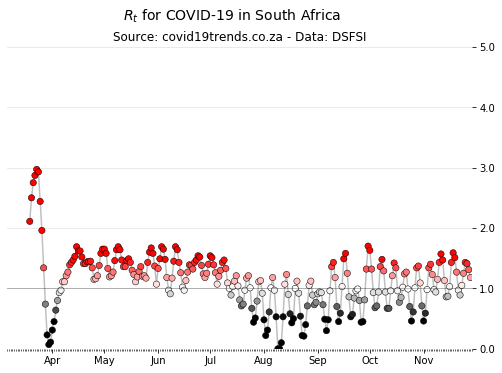

In [242]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [243]:
states_rt_i = states_all_rt_i.loc[state_filter]

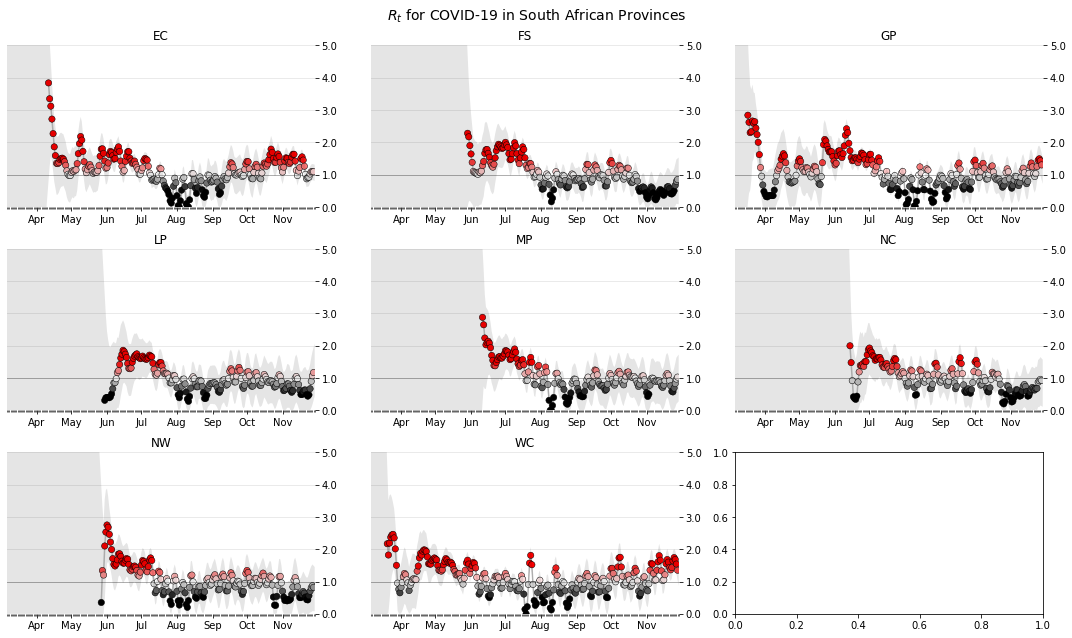

In [244]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [245]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [246]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

ML  High_90  Low_90
state                           
EC         1.09     1.32    0.82
FS         0.85     1.50    0.09
GP         1.30     1.68    0.84
LP         1.17     1.94    0.30
MP         1.03     1.68    0.24
NC         0.93     1.61    0.13
NW         0.82     1.49    0.08
Total RSA  1.18     0.00    0.00
WC         1.35     1.60    1.05

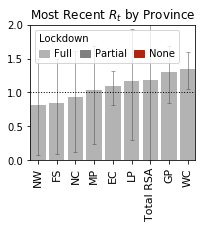

In [247]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

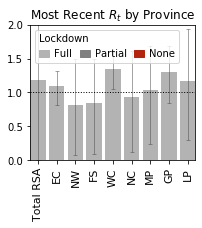

In [248]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

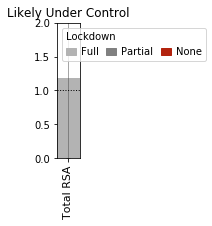

In [249]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

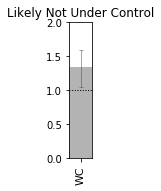

In [250]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()